기존의 모델에서 데이터를 개선하여 모델의 성능을 높여 보겠습니다.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

우선 항상 같은 결과를 보장하기 위해 랜덤 시드를 고정하겠습니다.

In [2]:
# 공정한 비교를 위한 랜덤 시드 고정
import numpy as np
import random

def set_seed(random_seed):
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)  # if use multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(random_seed)
    random.seed(random_seed)

set_seed(14)

## 정규화 영향 확인

데이터 정규화가 정말 모델의 성능에 영향을 미치는지 확인해 보도록 하겠습니다!

정규화를 수행한 데이터와 수행하지 않은 데이터로 같은 구조의 모델을 학습한 뒤, 두 모델의 성능을 비교하는 식으로 진행해 보겠습니다.

In [61]:
# 데이터 로딩

# 정규화를 수행하지 않는 transform
transform = transforms.Compose([
    transforms.Lambda(lambda x: torch.tensor(np.array(x), dtype=torch.float32))
])

# 정규화를 수행하는 transform
norm_transform = transforms.Compose([transforms.ToTensor()])

train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

norm_train_data = datasets.MNIST(root='./data', train=True, download=True, transform=norm_transform)
norm_test_data = datasets.MNIST(root='./data', train=False, download=True, transform=norm_transform)

# 정규화를 수행하지 않은 데이터로더
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

# 정규화를 수행한 데이터로더
norm_train_loader = DataLoader(norm_train_data, batch_size=64, shuffle=True)
norm_test_loader = DataLoader(norm_test_data, batch_size=64, shuffle=False)

In [62]:
# 간단한 모델 정의
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)  # 입력 크기 28*28
        self.fc2 = nn.Linear(128, 10)     # 출력 크기 10 (0~9 숫자)

    def forward(self, x):
        x = x.view(-1, 28*28)  # 28x28 이미지를 1차원 벡터로 변환
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.fc2(x)
        return x

model = SimpleNN()
norm_model = SimpleNN()

학습하기 전, 정규화 데이터로 학습한 모델과 정규화 데이터로 학습하지 않은 모델의 내부 변화를 확인하기 위해 모델의 중간 레이어 결과를 먼저 출력하겠습니다.

In [63]:
sample = train_data[0][0].view(-1, 28*28)

before = model.fc1(sample)

norm_sample = norm_train_data[0][0].view(-1, 28*28)

norm_before = norm_model.fc1(norm_sample)

이제 각 모델을 학습하고 결과를 확인해 봅시다.

In [64]:
def training(model, train_loader):
    # 모델, 손실 함수, 옵티마이저 정의
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01)

    # 모델 훈련
    for epoch in range(5):  # 5번 학습
        model.train()
        for data, target in train_loader:
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

        print(f'Epoch {epoch+1}, Loss: {loss.item():.4f}')

In [65]:
# 정규화 하지 않은 데이터로 모델 학습

training(model, train_loader)

Epoch 1, Loss: 1.2022
Epoch 2, Loss: 1.3916
Epoch 3, Loss: 0.7372
Epoch 4, Loss: 0.7747
Epoch 5, Loss: 1.4148


In [66]:
# 정규화 한 데이터로 모델 학습

training(norm_model, norm_train_loader)

Epoch 1, Loss: 0.5313
Epoch 2, Loss: 0.4294
Epoch 3, Loss: 0.1582
Epoch 4, Loss: 0.1488
Epoch 5, Loss: 0.1908


In [67]:
# 모델 성능 테스트
def evaluate(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():  # 테스트 중에는 기울기 계산 필요 없음
        for data, target in test_loader:
            output = model(data)
            _, predicted = torch.max(output, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

    accuracy = 100 * correct / total
    print(f'Accuracy: {accuracy:.2f}%')

print("정규화 하지 않은 데이터로 학습한 모델의 정확도")
evaluate(model, test_loader)
print("정규화 한 데이터로 학습한 모델의 정확도 :")
evaluate(norm_model, norm_test_loader)

정규화 하지 않은 데이터로 학습한 모델의 정확도
Accuracy: 58.31%
정규화 한 데이터로 학습한 모델의 정확도 :
Accuracy: 91.33%


두 모델의 테스트셋 정확도의 차이가 거의 40% 정도 차이나는 것을 확인할 수 있습니다. 엄청난 차이죠?

왜 이런 차이가 발생했을까요? 학습하는 동안 모델이 어떻게 변화했는지 확인해 봅시다.

두 모델의 변화를 살펴보기 위해 중간 모델 결과를 출력해 보겠습니다.

In [69]:
sample = train_data[0][0].view(-1, 28*28)

after = model.fc1(sample)

norm_sample = norm_train_data[0][0].view(-1, 28*28)

norm_after = norm_model.fc1(norm_sample)

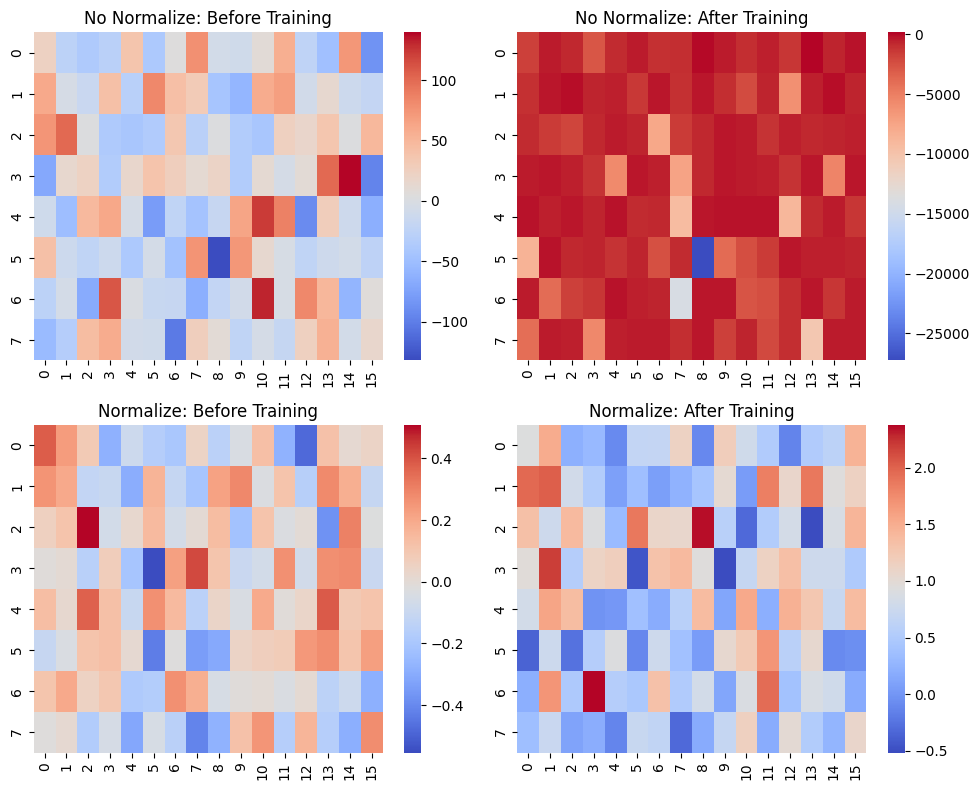

In [70]:
import seaborn as sns
import matplotlib.pyplot as plt

# 중간 레이어 출력 값을 2D 형태로 변형
before_reshaped = before.detach().reshape(8, -1)  # 8x16 형태 (128 뉴런 기준)
after_reshaped = after.detach().reshape(8, -1)
norm_before_reshaped = norm_before.detach().reshape(8, -1)
norm_after_reshaped = norm_after.detach().reshape(8, -1)

# 히트맵 시각화
fig, ax = plt.subplots(2, 2, figsize=(10, 8))

sns.heatmap(before_reshaped, cmap="coolwarm", ax=ax[0, 0])
ax[0, 0].set_title("No Normalize: Before Training")

sns.heatmap(after_reshaped, cmap="coolwarm", ax=ax[0, 1])
ax[0, 1].set_title("No Normalize: After Training")

sns.heatmap(norm_before_reshaped, cmap="coolwarm", ax=ax[1, 0])
ax[1, 0].set_title("Normalize: Before Training")

sns.heatmap(norm_after_reshaped, cmap="coolwarm", ax=ax[1, 1])
ax[1, 1].set_title("Normalize: After Training")

plt.tight_layout()
plt.show()

그래프의 왼쪽과 오른쪽은 각각 학습 전과 학습 후의 모델 출력을 나타내고, 위는 비정규화 모델, 아래는 정규화 모델입니다.

두 모델의 학습 전과 학습 후의 색상 변화를 보면,
* 비정규화 모델은 학습 후에 출력값들이 매우 작은 음수 값을 갖게 된 것을 볼 수 있습니다.
* 반면 정규화 모델은 학습 후에 더 -0.5에서 2.0 사이로 차이가 적은 분포를 보이는 것을 알 수 있습니다.

이처럼 **정규화는 모델이 학습하는 과정에서 다양한 입력 값의 범위 차이를 줄여 더 효과적으로 학습할 수 있도록 도와줍니다.**

## 데이터셋의 영향

모델에 가장 큰 영향을 미치는 데이터의 요소 중 하나는 데이터셋의 양입니다. 데이터셋의 양이 모델 성능에 어떤 영향을 미치는지 살펴봅시다.

In [59]:
from sklearn.model_selection import train_test_split

train_data = norm_train_data
test_data = norm_test_data

# 학습 데이터의 양을 12000개로 줄임.
train_small_data, _ = train_test_split(train_data, train_size=0.2, random_state=14)

print(len(train_small_data))

small_train_loader = DataLoader(train_small_data, batch_size=64, shuffle=True)

12000


In [ ]:
model_small = SimpleNN()

training(model_small, small_train_loader)

Epoch 1, Loss: 1.9306
Epoch 2, Loss: 1.3685
Epoch 3, Loss: 1.0631
Epoch 4, Loss: 0.8463
Epoch 5, Loss: 0.6848


In [ ]:
evaluate(model_small, test_loader)

Accuracy: 85.54%


전체 60,000장 데이터로 학습한 모델보다 정확도가 6% 정도(91% vs 85%) 떨어진 것을 확인할 수 있습니다.

이렇듯 데이터셋의 양을 늘리는 것만으로도 모델의 성능을 향상시킬 수 있습니다.

## 데이터셋의 양을 증가시켜보자 (Data Augmentation)

그렇다면 데이터를 더 이상 수집할 수 없다면 어떡할까요?

기존의 데이터들을 변형하여 새로운 데이터처럼 모델에 학습 시키는 방법을 데이터 증강(Data Augmentation)이라고 합니다.

In [57]:
# 데이터 증강 기법 적용
aug_transform = transforms.Compose([
    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1)),  # 가로/세로 0~10% 이동, 0~10% 확대
    transforms.ToTensor(),  # 0~255 → 0~1 정규화
])

aug_train_data = datasets.MNIST(root='./data', train=True, download=True, transform=aug_transform)
aug_train_loader = DataLoader(aug_train_data, batch_size=64, shuffle=True)

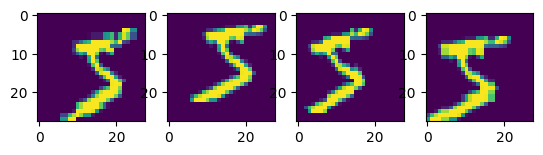

In [60]:
# 적용된 증강 기법 확인

to_pil = transforms.ToPILImage()
sample = to_pil(train_data[0][0])

fig, ax = plt.subplots(1, 4)

for i in range(4):
    img = aug_transform(sample)
    ax[i].imshow(img.squeeze())

In [71]:
model_aug = SimpleNN()

training(model_aug, aug_train_loader)
evaluate(model_aug, test_loader)

Epoch 1, Loss: 1.5176
Epoch 2, Loss: 1.0718
Epoch 3, Loss: 0.9709
Epoch 4, Loss: 0.8283
Epoch 5, Loss: 0.8471
Accuracy: 86.92%


데이터 증강을 했는데 오히려 테스트셋 정확도가 3% 떨어진 것을 확인할 수 있습니다. (91% vs 88%)

이는 데이터 증강이 오히려 테스트셋의 특성과 다른 특성의 데이터를 만들어 냈기 때문입니다.

테스트셋은 전체적으로 숫자가 가운데에 위치하며 회전이 적은 경우가 많습니다.

따라서 숫자를 움직이거나 회전을 적용한 증강 기법을 활용하면 테스트셋과 다른 이미지를 모델이 학습하게 되면서 오히려 성능이 떨어질 수 있습니다.

하지만 테스트셋에 변형을 적용한 뒤에 증강 데이터로 학습한 모델(model_aug)과 일반 데이터로 학습한 모델(model_small)의 성능을 테스트해보면, model_aug의 성능이 더 좋은 것을 확인할 수 있다.

In [72]:
aug_test_data = datasets.MNIST(root='./data', train=False, download=True, transform=aug_transform)
aug_test_loader = DataLoader(aug_test_data, batch_size=64, shuffle=False)

print("증강되지 않은 데이터로 학습한 모델")
evaluate(norm_model, aug_test_loader)

print("증강된 데이터로 학습한 모델")
evaluate(model_aug, aug_test_loader)

증강되지 않은 데이터로 학습한 모델
Accuracy: 52.59%
증강된 데이터로 학습한 모델
Accuracy: 74.73%


MNIST의 테스트셋에서는 잘 먹히지 않았지만, 그렇다고 데이터셋 증강이 무조건 좋지 않은 것은 아닙니다.

데이터셋의 특성에 따라 증강의 효과가 달라질 수 있기 때문이죠.

이번엔 CIFAR-10 데이터셋에 똑같은 증강 기법을 적용해 모델을 학습해 보겠습니다.

In [77]:
aug_transform = transforms.Compose([
    transforms.Pad(padding=10, padding_mode='edge'),
    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1)),  # 가로/세로 0~10% 이동, 0~10% 확대
    transforms.CenterCrop(32), # cifar 이미지는 32x32 이므로,
    transforms.ToTensor(),  # 0~255 → 0~1 정규화
])

# 증강이 적용되지 않은 훈련 데이터
cifar_train_data = datasets.CIFAR10(root='./data', train=True, download=True, transform=norm_transform)
cifar_test_data = datasets.CIFAR10(root='./data', train=False, download=True, transform=norm_transform)

cifar_train_loader = DataLoader(cifar_train_data, batch_size=64, shuffle=True)
cifar_test_loader = DataLoader(cifar_test_data, batch_size=64, shuffle=False)

# 증강이 적용된 훈련 데이터
aug_cifar_train_data = datasets.CIFAR10(root='./data', train=True, download=True, transform=aug_transform)

aug_cifar_train_loader = DataLoader(aug_cifar_train_data, batch_size=64, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


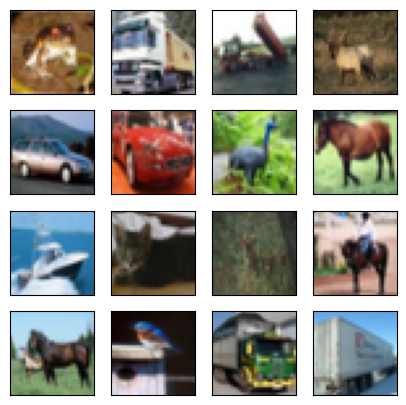

In [7]:
# CIFAR-10 데이터셋의 예시
import matplotlib.pyplot as plt

fig, ax = plt.subplots(4, 4, figsize=(5, 5))

for i in range(16):
    ax[i//4][i%4].imshow(cifar_train_data[i][0].permute(1, 2, 0))
    ax[i//4][i%4].set_xticks([])
    ax[i//4][i%4].set_yticks([])

In [52]:
class SimpleNNforCIFAR(nn.Module):
    def __init__(self):
        super(SimpleNNforCIFAR, self).__init__()
        self.fc1 = nn.Linear(32*32*3, 256)  # 입력 크기 28*28
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)     # 출력 크기 10 (0~9 숫자)

    def forward(self, x):
        x = x.view(-1, 32*32*3)  # 28x28 이미지를 1차원 벡터로 변환
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.fc2(x)
        x = torch.relu(x)
        x = self.fc3(x)

        return x

cifar_model = SimpleNNforCIFAR()
cifar_aug_model = SimpleNNforCIFAR()

In [53]:
# 각 모델 훈련

training(cifar_model, cifar_train_loader)
training(cifar_aug_model, aug_cifar_train_loader)

Epoch 1, Loss: 1.8883
Epoch 2, Loss: 1.9309
Epoch 3, Loss: 1.7515
Epoch 4, Loss: 1.6741
Epoch 5, Loss: 1.4493
Epoch 1, Loss: 1.9740
Epoch 2, Loss: 2.2073
Epoch 3, Loss: 2.2105
Epoch 4, Loss: 1.8217
Epoch 5, Loss: 1.8025


In [54]:
# 각 모델 테스트

print("증강되지 않은 데이터로 학습한 모델")
evaluate(cifar_model, cifar_test_loader)
print("증강된 데이터로 학습한 모델")
evaluate(cifar_aug_model, cifar_test_loader)

증강되지 않은 데이터로 학습한 모델
Accuracy: 34.93%
증강된 데이터로 학습한 모델
Accuracy: 37.16%


CIFAR-10 데이터셋에선 증강 기법이 효과가 있는 것을 알 수 있습니다!

이는 CIFAR-10 데이터가 MNIST에 비해 더 복잡한 패턴을 가졌기 때문입니다. 따라서 최대한 다양한 유형의 패턴을 보는 것이 모델의 성능 향상에 유리하게 작용했을 가능성이 높습니다.